In [104]:
import numpy as np
import netCDF4 as nc
import copy
import matplotlib.pylab as plt 
from mpl_toolkits.basemap import Basemap
from collections import OrderedDict

In [105]:
def get_vel_proj(u_rho,v_rho):
    # projection
    u_plt = u_rho*(np.cos(angs)) + v_rho*(np.cos(np.pi/2 + angs))
    v_plt = u_rho*(np.sin(angs)) + v_rho*(np.sin(np.pi/2 + angs))

    return u_plt, v_plt

In [106]:
def outline_domain(ax,clon,clat):
    ax.plot(clon[0,:],clat[0,:],linewidth=3,color='k',latlon=True,zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=3,color='k',latlon=True,zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=3,color='k',latlon=True,zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=3,color='k',latlon=True,zorder=42)

In [113]:
def plt_map(fig,ax,map_type):
    
    mapid = Basemap(llcrnrlon = np.min(lon_psi) - map_offset, 
              llcrnrlat = np.min(lat_psi) - map_offset, 
              urcrnrlon = np.max(lon_psi) + map_offset,
              urcrnrlat = np.max(lat_psi) + map_offset, 
              #resolution = 'c',
              resolution = 'f',
              projection = 'merc', ax=ax)
    
    # Plot data specific to map type
    if map_type == 'vel':
        P = mapid.pcolormesh(lon_psi, lat_psi, c_spd, vmin=0,vmax=.5, cmap='YlOrRd',latlon=True,zorder=map_order+2)
        mapid.quiver(lon[1:-1:qfreq,1:-1:qfreq], lat[1:-1:qfreq,1:-1:qfreq], u_plt[::qfreq,::qfreq], v_plt[::qfreq,::qfreq], 
                 latlon=True,zorder=map_order+2)
        
        c_ticks = np.arange(0,.5+.01,.1)
        cbar_txt = 'Current Speed (m s$^{-1}$)'
        
    elif map_type == 'eke':
        P = mapid.pcolormesh(lon_psi, lat_psi, 10000*eke, vmin=0,vmax=400, cmap='nipy_spectral',latlon=True,zorder=map_order+2)
     
        c_ticks = np.arange(0,400+1,100)
        cbar_txt = 'Energy Per Unit Mass (cm$^{2}$ s$^{-1}$)'
    
    mapid.drawcoastlines(linewidth=2)
    mapid.fillcontinents(color='white')
    mapid.drawmapboundary(fill_color=(0.9,0.98,1))
    parallels = [10,11]
    # labels: [left,right,top,bottom]
    if ncol == 0:
        mapid.drawparallels(parallels,labels=[True,False,False,False],zorder=map_order+2,fontsize=20)
    else:
        mapid.drawparallels(parallels,labels=[False,False,False,False],zorder=map_order+2,fontsize=20)    
    meridians = [124,125]
    if nrow == 0:
        mapid.drawmeridians(meridians,labels=[False,False,True,False],zorder=map_order+2,fontsize=20)
    elif nrow == 2:
        mapid.drawmeridians(meridians,labels=[False,False,False,True],zorder=map_order+2,fontsize=20)   
    else:
        mapid.drawmeridians(meridians,labels=[False,False,False,False],zorder=map_order+2,fontsize=20)
        
    outline_domain(mapid,lon_vert,lat_vert)
    plt.setp(ax.spines.values(), color='black',linewidth=2,zorder=map_order+3)
    
    ax.text(.04,.91,surf_vel_dict[fil]['plt_lab'],zorder=60,fontsize=24,weight="bold",transform = ax.transAxes)
    
    # Colorbar
    if nfil==6:
        pos = ax.get_position() # get the position of the last subplot
        ax_top = axs1[0,0].get_position().height + axs1[0,0].get_position().y0 # get the original position 
        cax = fig.add_axes([pos.x0+1.02*pos.width, pos.y0, 0.06*pos.width, ax_top-pos.y0])
        cbar = fig.colorbar(P, cax=cax, orientation='vertical')
        cax.set_yticks(c_ticks)
        cax.tick_params(labelsize=20)
        cbar.set_label(cbar_txt,labelpad =22, va='center',ha='center',fontsize=24, weight="bold", rotation=270)
        # Outline Colorbar
        plt.setp(cax.spines.values(), color='black',linewidth=2,zorder=map_order+3)

    

In [114]:
maphil_grid_fil = 'CamotesROMS_grid_file.nc'
grd_fid = nc.Dataset(maphil_grid_fil)
mask = grd_fid.variables['mask_rho'][:].squeeze()
water_only_ind = np.where(mask.ravel())[0]
h = grd_fid.variables['h'][:].squeeze()

# GENERATE mask for seeded-only points
seed_mask = np.zeros(h.shape,dtype=bool)
# MASK for coastal points and <10m depth
for jj in range(2,mask.shape[0]-1):
    for ii in range(2,mask.shape[1]-1):
        # IF POINT IS WATER
        if mask[jj,ii] == 1:
            coast = mask[jj-1,ii] + mask[jj+1,ii] + mask[jj,ii-1] + mask[jj,ii+1]
            # IF POINT TOUCHES COAST or IS LESS THAN 10m in DEPTH
            if  ((coast < 4) or (h[jj,ii]<10)) :
                seed_mask[jj,ii] = 1
                
# SEEDED_INDICES
seed_only_ind = np.where(seed_mask.ravel())[0]

# All the ROMS variables needed for plotting
lat = grd_fid.variables['lat_rho'][:]
lon = grd_fid.variables['lon_rho'][:]
mask_rho = grd_fid.variables['mask_rho'][:]
angs = grd_fid.variables['angle'][:][1:-1,1:-1]

lat_vert = grd_fid.variables['lat_vert'][:]
lon_vert = grd_fid.variables['lon_vert'][:]

lat_psi = grd_fid.variables['lat_psi'][:]
lon_psi = grd_fid.variables['lon_psi'][:]

nlat,nlon = lat.shape[:]

map_order=30
map_offset=0.01
qfreq=10

In [115]:
eke_fil_dir = './'
surf_vel_dict = {'base':{'ncfil':'surf_vel_2010-2015.nc','sav_str':'2010-2015'},
                 '2012-2014':{'ncfil':'surf_vel_2012-2014.nc','sav_str':'2012-2014','plt_lab':'F'},
                 '2012':{'ncfil':'surf_vel_Jun2011-May2012.nc','sav_str':'Jun2011-May2012','plt_lab':'C'},
                 '2013':{'ncfil':'surf_vel_Jun2012-May2013.nc','sav_str':'Jun2012-May2013','plt_lab':'D'},
                 '2014':{'ncfil':'surf_vel_Jun2013-May2014.nc','sav_str':'Jun2013-May2014','plt_lab':'E'},
                 'nem':{'ncfil':'surf_vel_2012-2014_NEMonsoon.nc','sav_str':'NEMonsoon','plt_lab':'A'},
                 'swm':{'ncfil':'surf_vel_2012-2014_SWMonsoon.nc','sav_str':'SWMonsoon','plt_lab':'B'}}

fil_order = ['base','nem','swm','2012','2013','2014','2012-2014']


base


/tmp/ipykernel_4001667/1292839268.py:32: RuntimeWarning: invalid value encountered in sqrt
  c_spd = np.sqrt(avg_u_rho**2+avg_v_rho**2)


nem


/net3/e1n/miniconda3/envs/mom6/lib/python3.10/site-packages/numpy/ma/core.py:6900: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


swm


/tmp/ipykernel_4001667/1292839268.py:32: RuntimeWarning: invalid value encountered in sqrt
  c_spd = np.sqrt(avg_u_rho**2+avg_v_rho**2)
/net3/e1n/miniconda3/envs/mom6/lib/python3.10/site-packages/numpy/ma/core.py:6900: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


2012


/tmp/ipykernel_4001667/1292839268.py:32: RuntimeWarning: invalid value encountered in sqrt
  c_spd = np.sqrt(avg_u_rho**2+avg_v_rho**2)
/net3/e1n/miniconda3/envs/mom6/lib/python3.10/site-packages/numpy/ma/core.py:6900: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


2013


/tmp/ipykernel_4001667/1292839268.py:32: RuntimeWarning: invalid value encountered in sqrt
  c_spd = np.sqrt(avg_u_rho**2+avg_v_rho**2)
/net3/e1n/miniconda3/envs/mom6/lib/python3.10/site-packages/numpy/ma/core.py:6900: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


2014


/tmp/ipykernel_4001667/1292839268.py:32: RuntimeWarning: invalid value encountered in sqrt
  c_spd = np.sqrt(avg_u_rho**2+avg_v_rho**2)
/net3/e1n/miniconda3/envs/mom6/lib/python3.10/site-packages/numpy/ma/core.py:6900: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


2012-2014


/tmp/ipykernel_4001667/1292839268.py:32: RuntimeWarning: invalid value encountered in sqrt
  c_spd = np.sqrt(avg_u_rho**2+avg_v_rho**2)
/net3/e1n/miniconda3/envs/mom6/lib/python3.10/site-packages/numpy/ma/core.py:6900: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


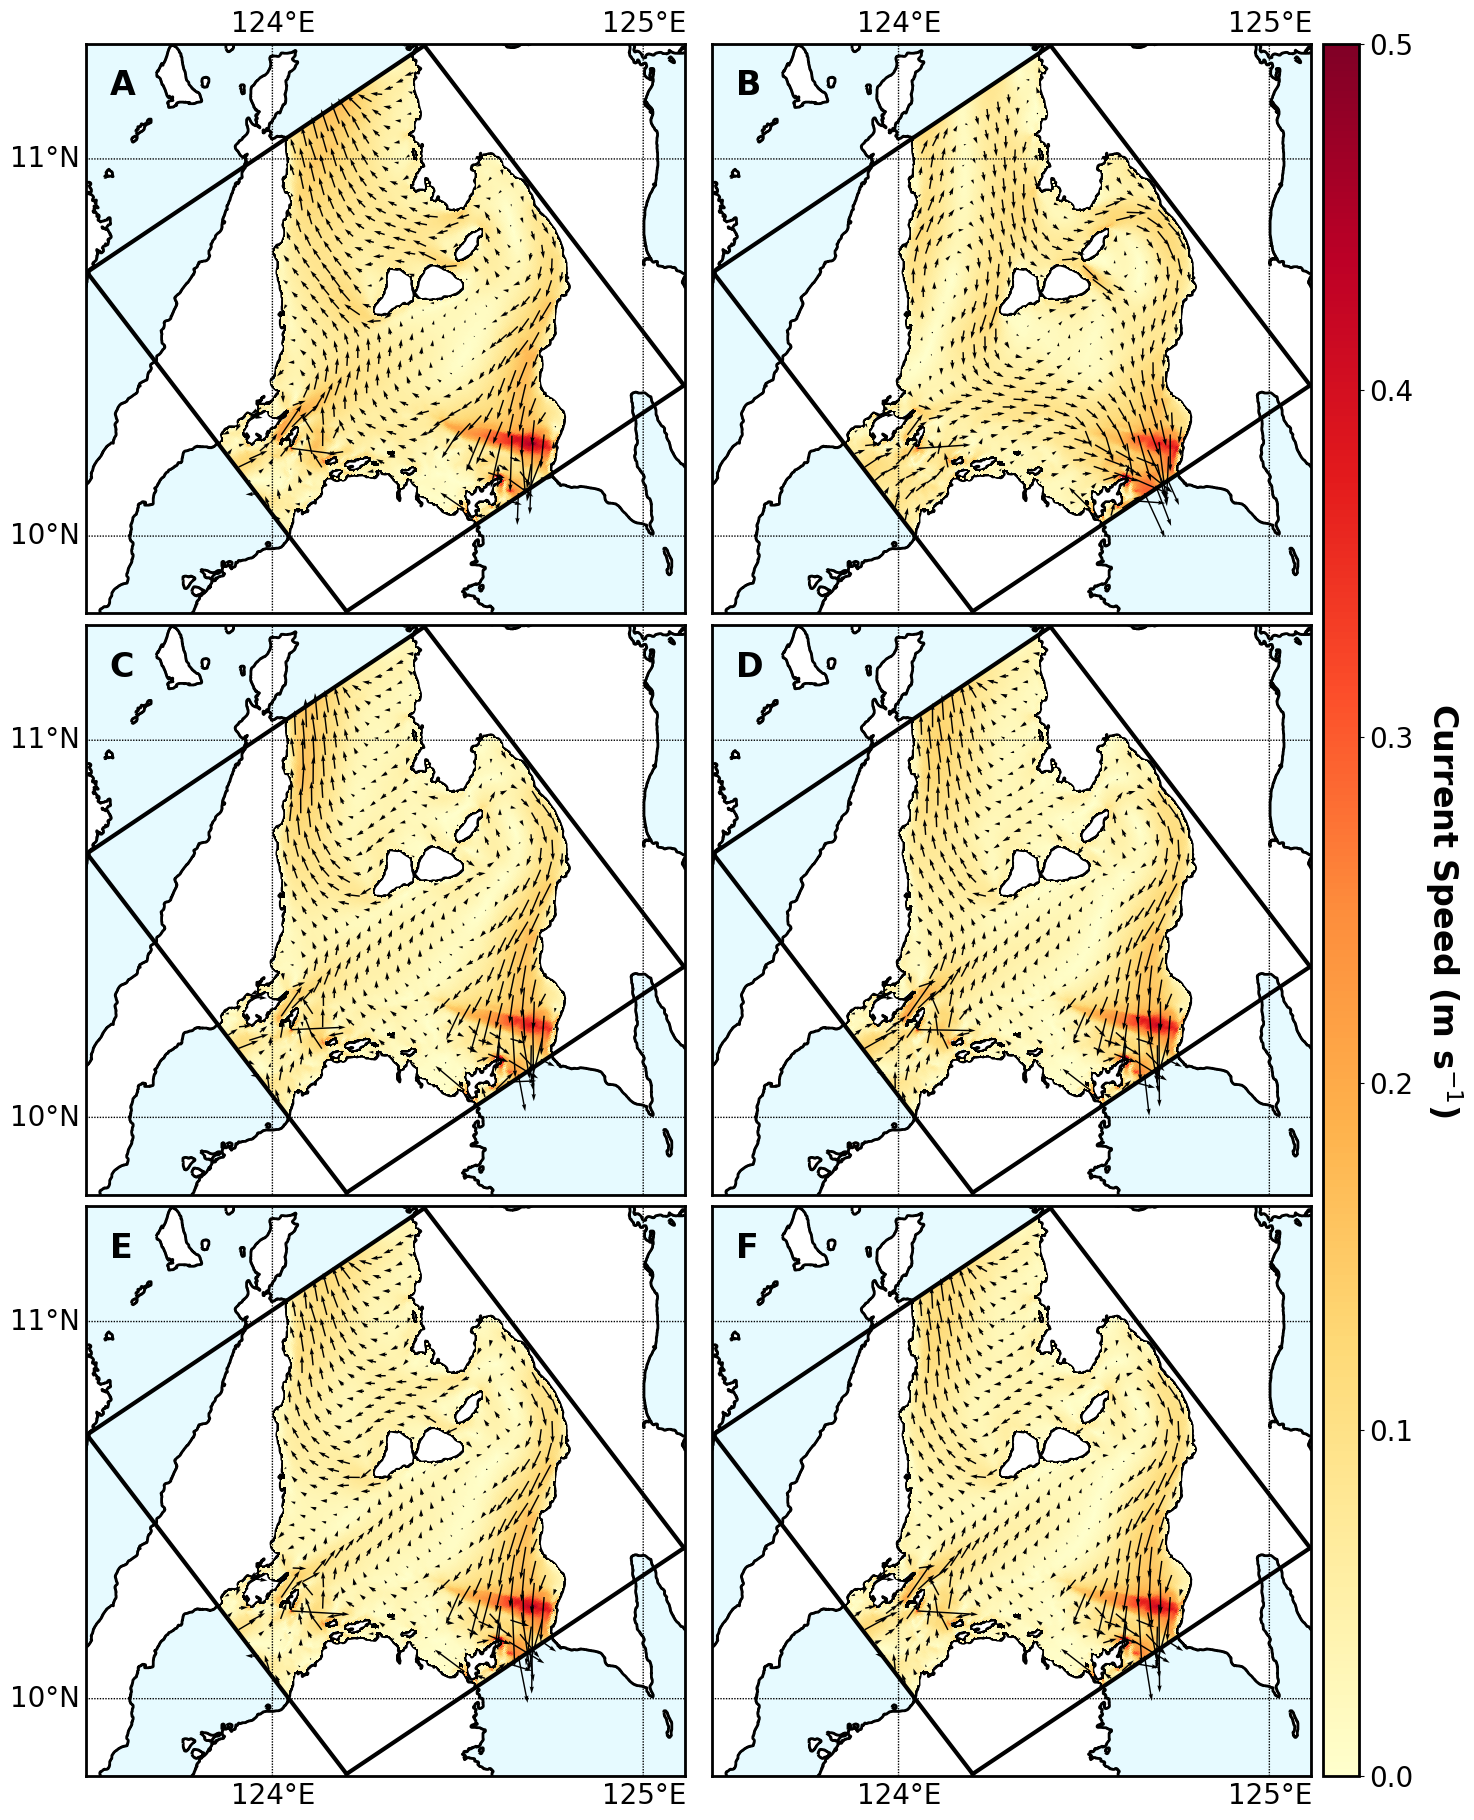

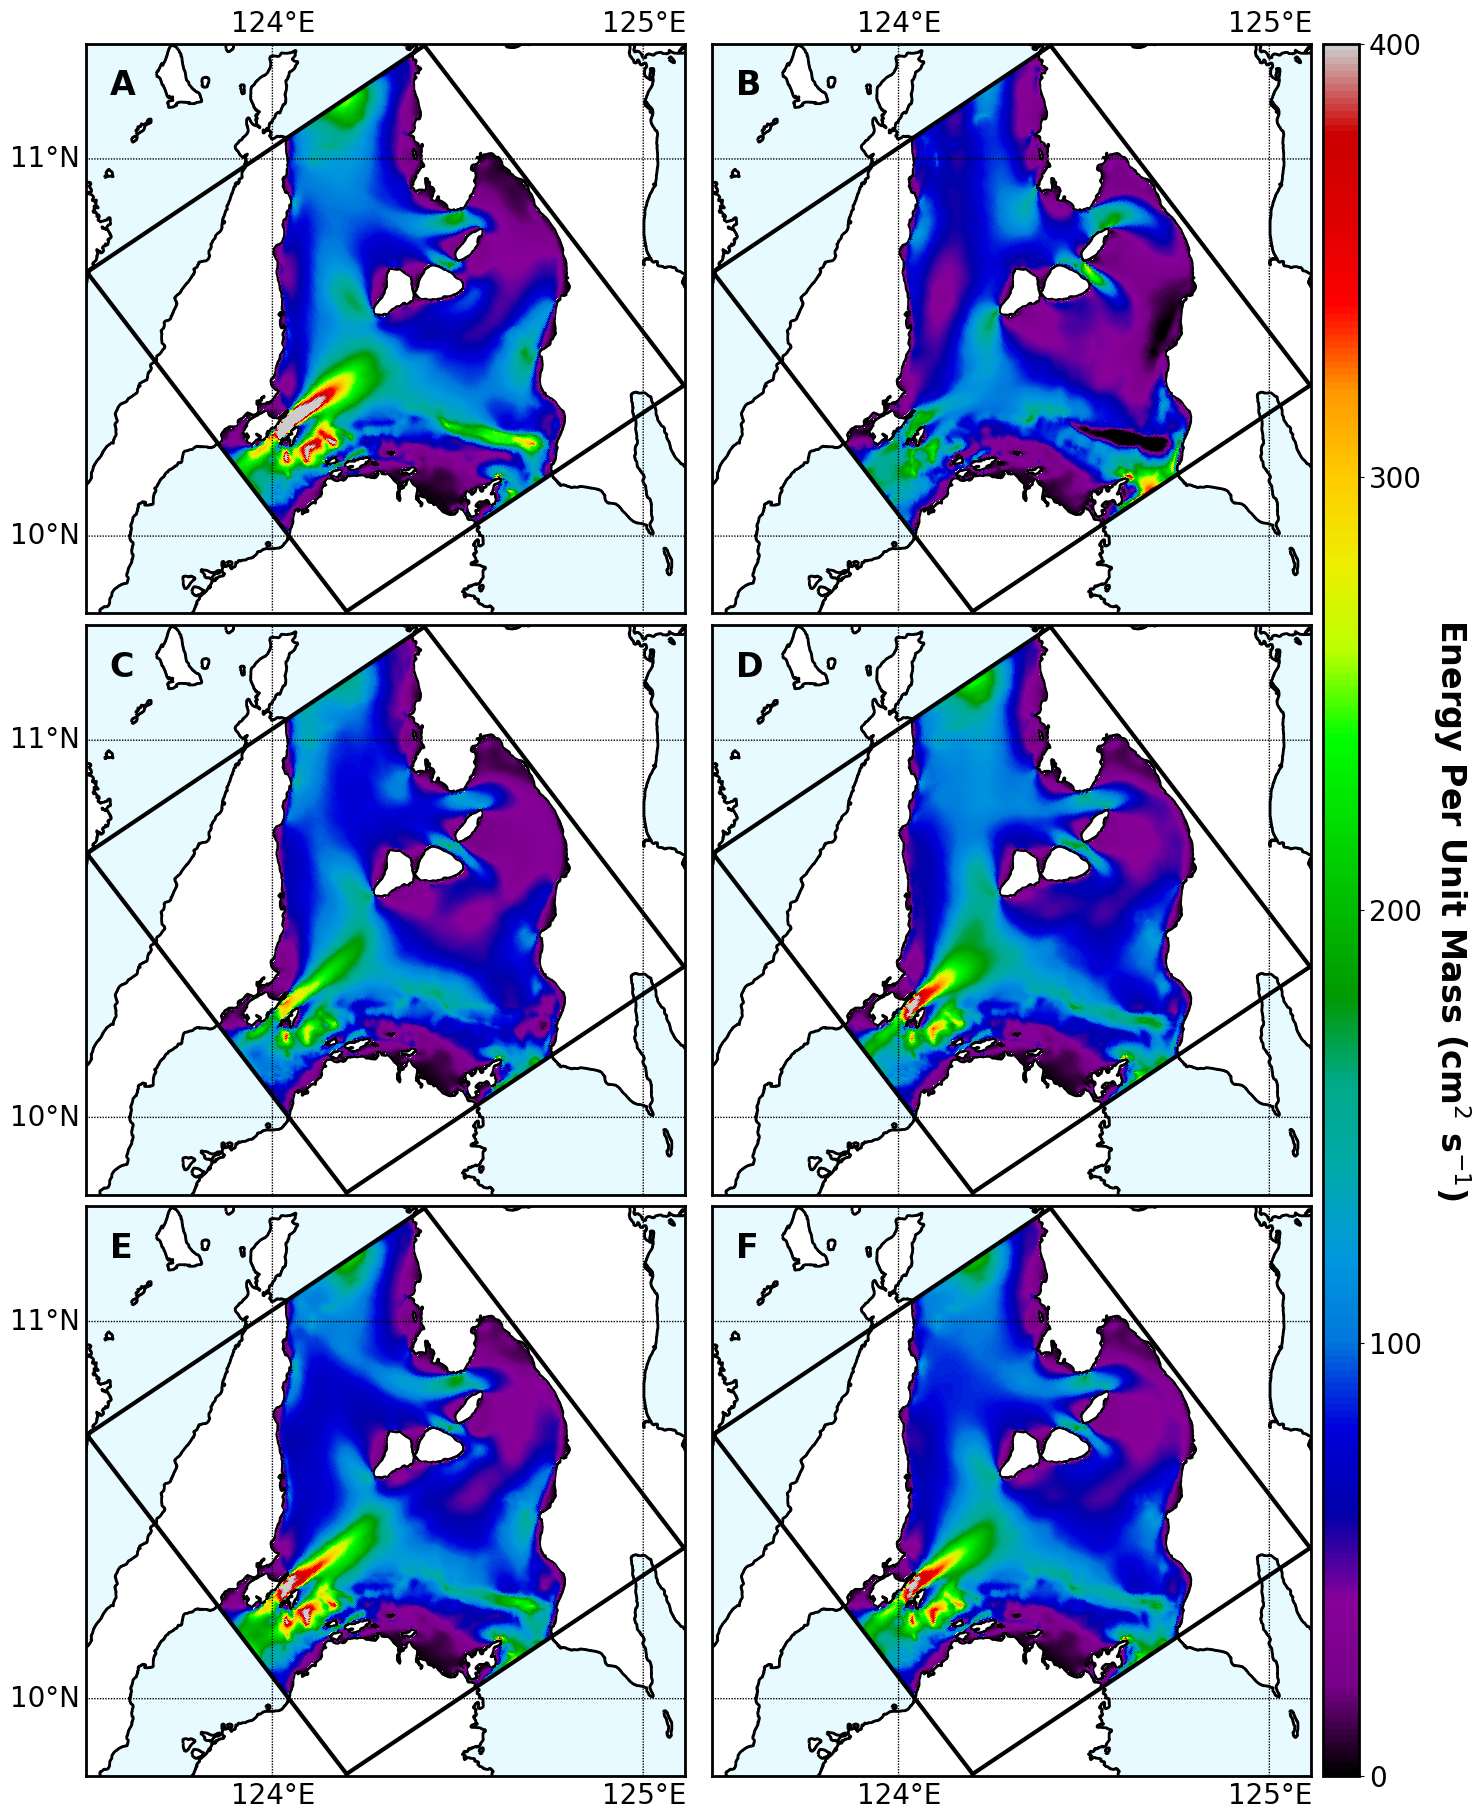

In [116]:
# create two figures
fig1, axs1 = plt.subplots(3, 2, sharex=True, sharey=True,
                          gridspec_kw={'hspace': 0.02, 'wspace': 0.02}, 
                          figsize = (16,22.5))

fig2, axs2 = plt.subplots(3, 2, sharex=True, sharey=True,
                          gridspec_kw={'hspace': 0.02, 'wspace': 0.02}, 
                          figsize = (16,22.5))

for fil,nfil in zip(fil_order,range(len(fil_order))):
    print(fil)
    
    nrow = int(np.floor((nfil-1)/2))
    ncol = (nfil-1)%2
    
    ncfil = eke_fil_dir + surf_vel_dict[fil]['ncfil']
    fid = nc.Dataset(ncfil)
    
    u = fid.variables['u'][:].squeeze()
    v = fid.variables['v'][:].squeeze()
        
    u_rho = ((u[:,1:-1,1:] + u[:,1:-1,:-1])/2.) # drop first and last row; average columns
    v_rho = ((v[:,1:,1:-1] + v[:,:-1,1:-1])/2.) # drop first and last column; average rows
    
    # Average Current Velocity and Speed
    # Verssion 1: Time mean, interpolate, (transform), square u and v, u2+v2, square root
    avg_u = np.mean(u,axis=0)
    avg_v = np.mean(v,axis=0)
    avg_u_rho = (avg_u[1:-1,1:] + avg_u[1:-1,:-1])/2
    avg_v_rho = (avg_v[1:,1:-1] + avg_v[:-1,1:-1])/2
    u_plt,v_plt = get_vel_proj(avg_u_rho,avg_v_rho)
    c_spd = np.sqrt(avg_u_rho**2+avg_v_rho**2)
    
    
    if fil == 'base':
        # AVERAGE EDDY KINETIC ENERGY: STORE REFERENCES
        uref = copy.deepcopy(u)
        vref = copy.deepcopy(v)
        
        uref_rho = copy.deepcopy(u_rho)
        vref_rho = copy.deepcopy(v_rho)
        
    else:
        # PLOT CURRENTS
        plt_map(fig1,axs1[nrow,ncol],'vel')
        
        # AVERAGE EDDY KINETIC ENERGY CALCULATIONS
        # Version 1: square time-mean reference u and v. subtract from time mean of u and v squared, respectively
        #            interpolate u and v to rhow points. add u and v 
        u_points_u = np.mean(u**2,axis=0) - np.mean(uref,axis=0)**2 # subtract reference
        v_points_v = np.mean(v**2,axis=0) - np.mean(vref,axis=0)**2 # subtract reference
         
        u_eke_rho = (u_points_u[1:-1,1:]+u_points_u[1:-1,:-1])/2 # interpolation to rho points
        v_eke_rho = (v_points_v[1:,1:-1]+v_points_v[:-1,1:-1])/2 # interpolation to rho points
    
        eke = (u_eke_rho + v_eke_rho)/2
        plt_map(fig2,axs2[nrow,ncol],'eke')
        
        
fig1.savefig('Fig2') 
fig2.savefig('Fig3') 